In [10]:
import roboticstoolbox as rtb
from roboticstoolbox.robot.DHLink import PrismaticDH, RevoluteDH
from spatialmath import *
import numpy as np
import math
import sympy as sp
import random
from error import *

In [34]:
class Sim():
    def __init__(self): 
        # 整体的运动学模型
        self.coeff = 0
        self.BZRobot = rtb.DHRobot([
            PrismaticDH(a=0, alpha=math.pi/2, theta=math.pi/2, offset=0), # LINK1
                # 平移误差器
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),     
                # 旋转误差器
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
 
            PrismaticDH(a=0, alpha=math.pi/2, theta=math.pi/2, offset=0),   # LINK2
                # 平移误差器
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),     
                # 旋转误差器
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
            PrismaticDH(a=0, alpha=0, theta=0, offset=0),   # LINK3
                # 平移误差器
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),     
                # 旋转误差器
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
            RevoluteDH(a=0, alpha=0, d=0),  # LINK4
                # 平移误差器
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),
                PrismaticDH(a=0, alpha=math.pi/2, offset=self.coeff, theta=math.pi/2),     
                # 旋转误差器
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
                RevoluteDH(a=0, alpha=math.pi/2, d=self.coeff, offset=math.pi/2),
        ], name="BZRobot")

        self.BZRobot.plot([1]+[0]*6+[1]+[0]*6+[1]+[0]*6+[0]+[0]*6);
        # TODO: 展示28个自由度


        # Set value
        self.L1_error = [d_z1, d_x1, d_y1, e_z1, e_x1, e_y1]
        self.L2_error = [d_z2, d_x2, d_y2, e_z2, e_x2, e_y2]
        self.L3_error = [d_z3, d_x3, d_y3, e_z3, e_x3, e_y3]
        self.L4_error = [d_z4, d_x4, d_y4, t_z, e_x4, e_y4]  # 注意，e_z4已经被弃用
        self.paraList = [p_z] + self.L1_error + [p_x] + self.L2_error + [p_y] + self.L3_error + [e_z4] + self.L4_error
    def run(self, printFlag=False):
        global P_err    # 使用全局变量
        # NOTE!
        # 注意：由于坐标系不同，所以误差的角标不加区分
        # BUG!!!!!!!!!!
        # 位置误差控制在0.001m以内
        sand1 = random.uniform(-1, 1)
        sand2 = random.uniform(-1, 1)
        displace_error = 0.001 * 5 * sand1
        # 角度误差控制在1度，即0.017弧度以内
        angle_error = 0.017  * 10 * sand2
        # 末端为吸盘端，认为主要的角度误差产生在z轴上
        angle_error_z = 0.017 * 10
        angle_error_x = 0.017 * 0.1 * sand2
        angle_error_y = 0.017 * 0.1 * sand2
        
        valueDic = {
            a1: 0, b1: 0, c1: 0,
            a2: 0, b2: 0, c2: 0,
            a3: 0, b3: 0, c3: 0,

            p_x: 0.1, p_y: 0.1, p_z: 0.1,
            
            e_x1: angle_error, e_y1: angle_error, e_z1: angle_error,
            e_x2: angle_error, e_y2: angle_error, e_z2: angle_error,
            e_x3: angle_error, e_y3: angle_error, e_z3: angle_error,
            e_x4: angle_error_x, e_y4: angle_error_y, 
            e_z4: 0,    # NOTE! e_z4已经被弃用!!! 设置为0！！！
            d_x1: displace_error, d_y1: displace_error, d_z1: displace_error,
            d_x2: displace_error, d_y2: displace_error, d_z2: displace_error,
            d_x3: displace_error, d_y3: displace_error, d_z3: displace_error,
            d_x4: displace_error, d_y4: displace_error, d_z4: displace_error,
            t_z: angle_error_z
        }

        subList = [
            (d_x1, valueDic[d_x1]), (d_y1, valueDic[d_y1]), (d_z1, valueDic[d_z1]),
            (d_x2, valueDic[d_x2]), (d_y2, valueDic[d_y2]), (d_z2, valueDic[d_z2]),
            (d_x3, valueDic[d_x3]), (d_y3, valueDic[d_y3]), (d_z3, valueDic[d_z3]),
            (d_x4, valueDic[d_x4]), (d_y4, valueDic[d_y4]), (d_z4, valueDic[d_z4]),
            (e_x1, valueDic[e_x1]), (e_y1, valueDic[e_y1]), (e_z1, valueDic[e_z1]),
            (e_x2, valueDic[e_x2]), (e_y2, valueDic[e_y2]), (e_z2, valueDic[e_z2]),
            (e_x3, valueDic[e_x3]), (e_y3, valueDic[e_y3]), (e_z3, valueDic[e_z3]),
            (e_x4, valueDic[e_x4]), (e_y4, valueDic[e_y4]), (e_z4, valueDic[e_z4]),
            (t_z, valueDic[t_z]),
            # 控制量
            (p_x, valueDic[p_x]), (p_y, valueDic[p_y]), (p_z, valueDic[p_z]),
            # 几何初始值（全部收缩在原点）
            (a1, 0), (b1, 0), (c1, 0),
            (a2, 0), (b2, 0), (c2, 0),
            (a3, 0), (b3, 0), (c3, 0),
        ]



        expect_displacement = [valueDic[p_x]]+[0]*6+[valueDic[p_y]]+[0]*6+[valueDic[p_z]]+[0]*6+[0]+[0]*6
        if printFlag:
            print(self.BZRobot.fkine(expect_displacement))   # 目标位置
        mat_sim_exp = self.BZRobot.fkine(expect_displacement).A
        if printFlag:
            self.BZRobot.plot(expect_displacement);
        x_sim_exp = mat_sim_exp[0][3]
        y_sim_exp = mat_sim_exp[1][3]
        z_sim_exp = mat_sim_exp[2][3]
        if printFlag:
            print(x_sim_exp, y_sim_exp, z_sim_exp)

        # 创造fkine对应的列表
        real_displacement = []
        for symbol in self.paraList:
            real_displacement.append(valueDic[symbol])

        # 计算
        mat_sim_real = self.BZRobot.fkine(real_displacement).A
        if printFlag:
            print(mat_sim_real)
            self.BZRobot.plot(real_displacement);
        x_sim_real = mat_sim_real[0][3]
        y_sim_real = mat_sim_real[1][3]
        z_sim_real = mat_sim_real[2][3]
        if printFlag:
            print(x_sim_real, y_sim_real, z_sim_real)

        precision = 5
        # 仿真得到的误差
        if printFlag:
            print("仿真得到的误差")
        x_sim_error = x_sim_real - x_sim_exp
        y_sim_error = y_sim_real - y_sim_exp
        z_sim_error = z_sim_real - z_sim_exp
        if printFlag:
            print(round(x_sim_error, precision), round(y_sim_error, precision), round(z_sim_error, precision))

        # 理论计算的误差
        P_err = P_err.subs(subList)
        if printFlag:
            print("理论计算的误差")
        x_theory_error = P_err[0]
        y_theory_error = P_err[1]
        z_theory_error = P_err[2]
        if printFlag:
            print(round(x_theory_error, precision), round(y_theory_error, precision), round(z_theory_error, precision))

        # 计算两者偏差
        if printFlag:
            print("计算两者偏差")
        x_bias_percent = (x_sim_error - x_theory_error) / x_theory_error
        y_bias_percent = (y_sim_error - y_theory_error) / y_theory_error
        z_bias_percent = (z_sim_error - z_theory_error) / z_theory_error
        # print(round(x_bias_percent, precision), round(y_bias_percent, precision), round(z_bias_percent, precision))
        return x_bias_percent, y_bias_percent, z_bias_percent


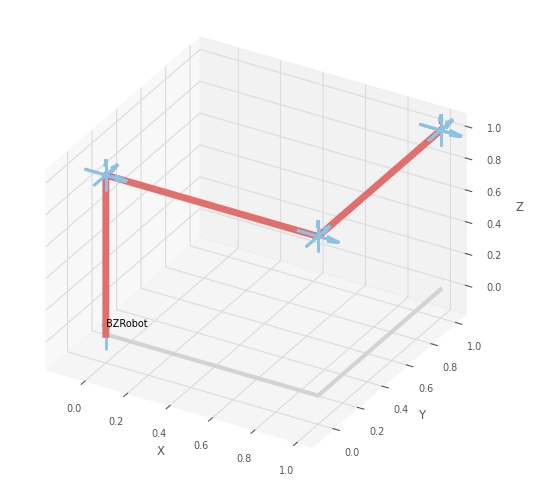

<Figure size 640x480 with 0 Axes>

In [35]:
sim = Sim()

In [41]:
resList = []
for i in range(1000):
    resList.append(sim.run())

In [42]:
resList = np.array(resList, dtype=np.float32)

In [43]:
resList.mean(axis=0)

array([-4.2790475,  3.9282157, -8.1711235], dtype=float32)

最终的结果为：[-0.694756242049820, -0.369563058316566, -0.335779615727142]
误差控制的还可以

In [44]:
# 画出分布图
import matplotlib.pyplot as plt
import pandas as pd

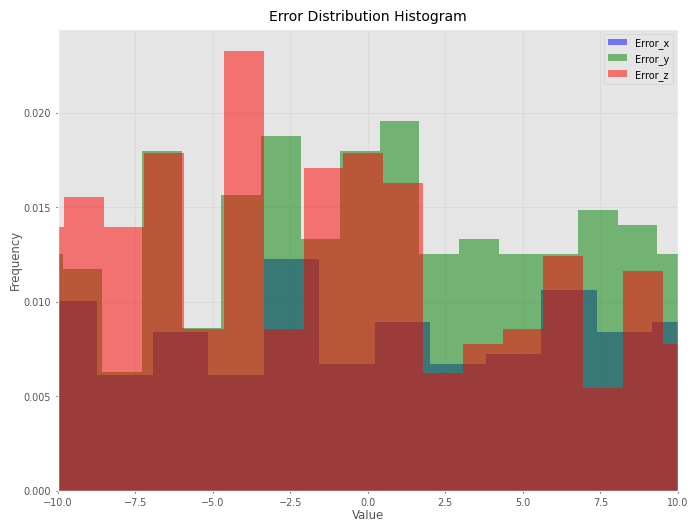

In [45]:
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
# 绘制三个直方图
n1, bins2, patches2 = ax.hist(resList[:, 0], bins=100, density=True, alpha=0.5, color='blue')
n2, bins2, patches2 = ax.hist(resList[:, 1], bins=100, density=True, alpha=0.5, color='green')
n3, bins3, patches3 = ax.hist(resList[:, 2], bins=100, density=True, alpha=0.5, color='red')

# 设置坐标轴范围和标签
ax.set_xlim([-10, 10])
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

plt.title('Error Distribution Histogram')
ax.legend(['Error_x', 'Error_y', 'Error_z'])

plt.show()